
<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/CV/5_Deteccion_Objetos/Deteccion_Objetos.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>

# Detección de objetos


En secciones anteriores,
introdujimos varios modelos para la clasificación de imágenes.
En las tareas de clasificación de imágenes,
suponemos que solo hay un único
objeto principale
en la imagen y solo nos enfocamos en como
reconocerlo.
Sin embargo, a menudo hay *múltiples* objetos de interés
en la imagen.
No solo queremos saber sus categorías, sino también sus posiciones específicas en la imagen.
Estás tareas son llamadas *detección de objetos* o *reconocimiento de objetos*.

La detección de objetos ha sido ampliamente aplicada en muchos campos.
Por ejemplo, la conducción autónoma necesita planificar
rutas de viaje
detectando las posiciones
de vehículos, peatones, caminos y obstáculos en las imágenes de video capturadas.
Además,
los robots pueden usar esta técnica
para detectar y localizar objetos de interés
a lo largo de su navegación por un entorno.
Es más,
sistemas de seguridad
pueden necesitar detectar objetos anormales, como intrusos o bombas.

En las próximas secciones, presentaremos
varios métodos de aprendizaje profundo para la detección de objetos.
Comenzaremos con una introducción.
a *posiciones* (o *ubicaciones*) de objetos.

In [ ]:
import torch
from matplotlib import pyplot as plt


Cargaremos la imagen de muestra que se usaremos en esta sección. Podemos ver que hay un perro en el lado izquierdo de la imagen y un gato en el lado derecho.
Son los dos objetos principales en esta imagen.

--2022-09-24 13:32:19--  https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/catdog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32576 (32K) [image/jpeg]
Saving to: ‘catdog.jpg’

catdog.jpg          100%[===================>]  31.81K  --.-KB/s    in 0s      

2022-09-24 13:32:20 (129 MB/s) - ‘catdog.jpg’ saved [32576/32576]



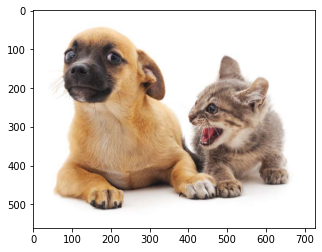

In [ ]:
!wget -O catdog.jpg https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/catdog.jpg
img = plt.imread("./catdog.jpg", format='jpg')
plt.imshow(img);

## Bounding Boxes

En detección de objetos,
normalmente usamos un *bounding boxes* para describir la ubicación espacial de un objeto.
Los bounding boxes son rectangular, que está determinado por las coordenadas $x$ y $y$ de la esquina superior izquierda del rectángulo y las coordenadas de la esquina inferior derecha.
Otra representación de los bounding boxes es la posición $(x, y)$
coordenadas del centro del bounding box y el ancho y el alto del cuadro.

Aquí definimos funciones para convertir entre estas dos
representaciones:
`box_corner_to_center` convierte desde las dos esquinas
representación a la representación centro-ancho-alto,
y `box_center_to_corner` es su inbersa.
El argumento de entrada `boxes` será un tensor bidimensional de
forma ($n$, 4), donde $n$ es el número de bounding boxes.

In [ ]:
def box_corner_to_center(boxes):
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

Vamos a definir los bounding boxes del perro y el gato en la imagen en base a las coordenadas.
El origen de las coordenadas en la imagen es la esquina superior izquierda de la imagen, y a la derecha y hacia abajo están los direcciones positivas de los ejes $x$ y $y$, respectivamente.


In [ ]:
# `bbox` es bounding box
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

Podemos ver que una es la inversa de la otra.

In [ ]:
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

Usaremos la siguiente función para poder verificar que tan precisos son los bounding boxes definidos.


In [ ]:
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Matplotlib espera un bounding box de la forma 
    # (esquina superior a la izquierda x, esquina superior a la izquierda y,  ancho, alto)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

Veamos como se ve esto.


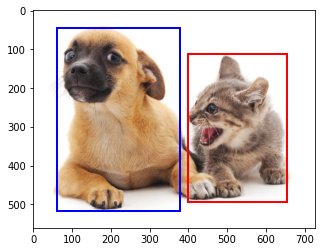

In [ ]:
fig = plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

# Anchor Boxes

Los algoritmos de detección de objetos generalmente
muestrean una gran cantidad de regiones en la imagen de entrada. Luego determinan si estas regiones contienen
objetos de interés y ajustan las coordenadas
de las regiones para predecir con mayor precisión los bounding boxes de nuestras etiquetas o grounding truth.
Diferentes modelos adoptan diferentes esquemas de muestreo de regiones.
Aquí presentamos uno de esos métodos:
Generamos múltiples bounding boxes con diferentes escalas y diferentes aspect ratios centradas en cada píxel.
Estos se denominan *anchor boxes*.

In [ ]:
import torch
from matplotlib import pyplot as plt

torch.set_printoptions(2)  # 2 cifras decimales

## Generación de Múltiples Anchor Boxes

A continuación generaremos múltiples anchor boxes de la siguiente manera:

1. Definimos una serie de tamaños o factores de escala $s_1, s_2, s_3, ..., s_n$
1. Definimos una serie de *aspect ratios*. Aspect ratio es el nombre del cociente entre el ancho y el alto de una imagen. usaremos las siguientes variables para estas cantidades. $r_1, r_2, r_3, ..., r_n$
1. Combinamos las variables anteriores de la siguiente manera: 
$$(s_1, r_1), (s_1, r_2), \ldots, (s_1, r_m), (s_2, r_1), (s_3, r_1), \ldots, (s_n, r_1).$$
De esta manera generamos $m + n - 1$ anchor boxes. Esto lo hacemos para evitar generar las $nm$ combinaciones posible y ahorramos tiempo de cálculo.
3. Finalmente, usamos los tamaños $h, w$ de la imagen original junto con $s_i, r_j$ para generar cada anchor box

En la siguiente función mostramos este procedimeinto

In [ ]:
def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel."""

    # obtemos el ancho y el alto de la entrada 
    in_height, in_width = data.shape[-2:]

    # definimos la cantidad de anchor boxes y si usamos GPU o CPU
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device) # guardamos s_i
    ratio_tensor = torch.tensor(ratios, device=device)# guardamos r_j

    # Si consideramos a cada pixel como una unidad $1 x 1$, entonces
    # tenemos el centro en (0.5, 0.5)
    offset_h, offset_w = 0.5, 0.5
    # de esta manera el pixel en 4,5 tiene su centro en 4.5, 5.5

    # Queremos que nuestro algorimos sea invariante en escala. 
    # decir, que el ancho y el alto sea 1, en alguna unidad de medida arbitraria
    steps_h = 1.0 / in_height  # eje y
    steps_w = 1.0 / in_width  # eje x

    # En la siguiente linea comentado, agarramos un tensor de la forma:
    #    [0, 1, 2, 3, ..., in_height - 1]
    # Luego lo escaleamos haciendo que el alto y el ancho de la imagen sea 1
    #    center_h = (torch.arange(in_height, device=device) + offset_h)
    #    center_h = center_h * steps_h
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w

    # Creamos dos vectores, shift_y y shift_x
    # En todos los casos shift_y[i], shift_x[i] coresponde al centro
    # con coordenadas x_i, y_i
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Generamos el ancho y el alto de cada anchor box
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # Handle rectangular inputs
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    ########
    # Hasta aqui hemos generado anchor boxes en la representación
    #     x_centro, y_centro, ancho, alto

    # Podemos modificara estos valores para devolverlos en la representación:
    #     x_superior_izq, y_superior_izq, x_inferior_der, y_inferior_der
    # Luego, a partir de los anchos y altos, preparamos nuevos tensores
    # para luego sumar los centros de nuestros anchor boxes. 
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2

    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)

    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

En el código anterior hemos definido los anchos y altos de nuestras anchor boxes de la siguiente manera:

$$a_{w}[i,j] = s_i\sqrt{r_j}\dfrac{h}{w}$$

$$a_{h}[i,j] = \dfrac{s_i}{\sqrt{r_j}}$$

En este punto, el origen de estas expresiones excede el alcance de la clase.

Veamos un ejemplo de como sería la salida de nuestra función

In [ ]:
img = plt.imread('catdog.jpg')
h, w = img.shape[:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

561 728


torch.Size([1, 2042040, 4])

Notemos que nuestra salida tiene la siguiente estructura:

`[tamaño de minilote, cantidad de anchor boxes, 4]`

Donde el 4 se refiera a las siguientes coordenadas:

  `(x_superior_izq, y_superior_izq, x_inferior_der, y_inferior_der)`

A continuación mostramos como transformar la salidad anterior, para obtener el conjunto de anchor boxes centradas en un píxel. Observe que en el ejemplo anterior tenemos 5 tipos de anchor boxes. Tambien debe recordar que hemos normalizado el ancho y el alto para que sean igual a 1 en ambas direcciones.



In [ ]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]
# boxes[250, 250, :, :] nos dará todos los anchor boxes centradas en 250, 250

tensor([0.06, 0.07, 0.63, 0.82])

Mostremos uno de estos conjuntos en la imagen de referencia.


In [ ]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""

# La mayoria de los que hacemos aquí es preparar las entradas para luego 
# graficarlas en matplotlib. 
# De hecho axes es una clase creada por matplotlib.

    def make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = make_list(labels)
    colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.detach(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

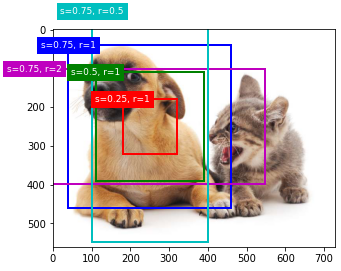

In [ ]:
bbox_scale = torch.tensor((w, h, w, h))
fig = plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

## Indice de Jaccard.

En el ejemplo anterior tenemos un anchor box que "bien" rodea al perro en la imagen. ¿Cómo se puede cuantificar "bien" aquí? 
Intuitivamente, podemos medir la similitud entre
el anchor box y el bounding box en nuestros labeles. Para esto utilizaremos 
el *índice de Jaccard*. Dados los conjuntos $\mathcal{A}$ y $\mathcal{B}$, su índice de Jaccard es el tamaño de su intersección dividido por el tamaño de su unión:

$$J(\mathcal{A},\mathcal{B}) = \frac{\left|\mathcal{A} \cap \mathcal{B}\right|}{\left| \mathcal{A} \cup \mathcal{B}\right|}.$$

El indice de Jaccard, tiene la característica que si $\mathcal{A}$ y $\mathcal{B}$ son iguales, entonces el indice es igual a 1. Además si la intersección es vacía, el índice vale 0. Se puede ver que para rectángulos, esta medida es sencilla de calcular. Esto se debe a que solo vemos identificar vértices de lso rectángulos 

![](http://d2l.ai/_images/iou.svg)

Veamos como implementar esto:

In [ ]:
def box_iou(boxes1, boxes2):
    """Compute pairwise IoU across two lists of anchor or bounding boxes."""

    # funcion anónima para cálculo de areas.
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    
    # Calculamos las areas de los boxes que recibiemos.
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)

    # Analizamos las esquinas superiores izquierdas de las dos cajas 
    # Nos quedamos con la que está más abajo y más a la derecha
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])

    # Analizamos las esquinas inferiores derechas de las dos cajas 
    # Nos quedamos con la que está más arriba y más a la izqueirda
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])

    # A partir de las esquinas elegidas, restamos sus coordenadas.
    # Si la diferencia es negativa, devolvemos 0 (el método clamp hace esto)
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)

    # Calculamos el area de la intersección
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    # Calculamos el area de la union
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

Si bien en los comentarios hemos definido la función para 2 boxes, en realidad, la función fuciona de igual manera para dos conjuntos cualesquiera de boxes. La razón por la que esto funciona tiene que ver con el manejo de indice que hemos hecho. En particular las lineas de la forma 

`A[:,None,:2]`

Vemos esto a continuación.

In [ ]:
A = torch.randn(2,4)
B = torch.randn(3,4)

print(A[:,:])
print()
print(B[:,None,:].shape)
print(B[:,None,:])
print()
print(torch.max(A[:,None,:2], B[:,:2]))

tensor([[-0.50,  2.17,  1.62,  2.16],
        [ 0.82, -1.99,  1.08,  0.59]])

torch.Size([3, 1, 4])
tensor([[[ 0.35,  0.77, -0.15, -1.35]],

        [[ 0.77,  1.06,  1.99,  1.43]],

        [[-2.60, -1.25,  1.83,  0.09]]])

tensor([[[ 0.35,  2.17],
         [ 0.77,  2.17],
         [-0.50,  2.17]],

        [[ 0.82,  0.77],
         [ 0.82,  1.06],
         [ 0.82, -1.25]]])


Luego, el *broadcastig* se encarga de manipular las dimensiones de longitud igual a 1, para obtener los resultados correctos.

## Etiquetando Anchor Boxes a partir de los datos de entrenamiento


Hasta aquí hemos mostrado como generar anchor boxes, pero no hemos dicho como detectar objetos con ellos. Durante el entrenamiento, a partir de nuestra imagenes generamos una gran cantidad de anchor boxes. Pero la primera pregunta que debemos hacernos es ¿qué hay adentro de nuestra anchor box? 

La respuesta hasta cierto punto es evidente. Dado que tenemos el índice de Jaccard, podemos comprar nuestras anchor boxes con las bounding boxes de nuestro dataset, y asignar a cada anchor box la categoría con mayor indice de Jaccard.

Aunque esto suena intuitivo, hay un problema. Hemos creado una función que en principio puede generar miles de anchor boxes. Es posible que la mayoría de ellas no tengan intersección con ninguno de los elementos de nuestro data set. Por esta razón, debemos refinar un poco más la manera de definir qué hay adentro de nuestra anchor box 


### Asignando clases a Anchor Boxes

Describimos un algoritmo para asigar clases detectadas a nuestros anchor boxes

1. Dado un conjunto de  anchor boxes  $A_1, A_2, \ldots, A_{n_a}$ y un conjunto de bounding boxes  $B_1, B_2, \ldots, B_{n_b}$ en una imagen de nuestro dataset, calculamos el indice de Jaccard entre elementos y lo guaramos en $\mathbf{X}$
  > * Suponemos que hay más anchor boxes que bounding boxes ( $n_a \geq n_b$ )
  >* $\mathbf{X}[i,j]$ es el indice de Jaccard entre A_i y B_j 

1. Buscamos el elemento más grande en la matriz $\mathbf{X}$ Sean sus indice $i$ y $j$, al anchor box $A[i]$ se le asigna la clase del bounding box $B[j]$.
2. Descartamos todos los elementos en la fila ${i}$ y la columna ${j}$ en la matriz $\mathbf{X}$. (Podemos hacer esto rellenando con -1)
  > Recuerde que el índice de Jaccard toma valores entre 0 y 1. 
3. Repetimos hasta que no nos queden bounding boxes en nuestra imagen de entrenamiento.
4. Luego, asignamos la clase con mayor indice de Jaccard a las anchor boxes restantes, solo si superan cierto umbral de tolerancia.

A continuación, la siguiente imágen ejemplifica el algoritmo.

![Assigning ground-truth bounding boxes to anchor boxes.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/anchor-label.svg?raw=1)



En la siguiente implementación, el paso 5 se realiza antes que el todos los demás paso. Esto en esencia no modifica el resultado final, pero tiene la ventaja de que que no requerimos calcular nuevamente el indice de Jaccard. 

In [ ]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """Assign closest ground-truth bounding boxes to anchor boxes."""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]

    #Calculamos el indice de Jaccard
    jaccard = box_iou(anchors, ground_truth)

    # Definimos un vector de longitud igual al número de anchor boxes.
    # De esta manera, si el i-ésimo elemento es 4, eso significa que 
    # al anchor box número i, le corresponde la clase 4 de nuestro dataset
    # Este vector lo inicializamos en -1
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)

    # Guardamos el mayor indice de Jaccard para cada anchor box asi como la 
    # clase a la que perteneces el bounding box correspondiente.
    max_ious, indices = torch.max(jaccard, dim=1)

    # Si el indice de Jaccard, no supera nuestro umbral de de referencia 
    # mantenemos el valor -1 con que que fue inicializado
    # Si lo supera, reemplazamos con el valor correspondiente.
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j

    # mascaras para descartar filas y columnas del tensor jaccard
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)

    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)  # buscamos el mayor indice de Jaccard
        
        # La forma con la que devolvemos el tensor con los indices de Jaccard
        # Nos obliga a hacer operaciones de división entera y modulo
        # para encontrar el número anchor box y de bounding box
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        
        anchors_bbox_map[anc_idx] = box_idx ## asgino anchor a grounding truth
        jaccard[:, box_idx] = col_discard ## relleno con -1!
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

En el código anterior hemos usado un par de prestaciones de torch que hasta ahora no habían sido comentadas. Estas son:

* `torch.nonzero`
* Método `__getitem__` para la clase `Tensor`, cuando recibe un `Tensor` de booleanos.
* `torch.argmax(A)` en compración a `torch.argmax(A, dim=1)`

La razón de usarlas en este momento, es que las mismas son las herramientas que necesitamos para el algortimos anterior. Vemos como funcionan.

In [ ]:
A = torch.nonzero(torch.tensor([1, 1, 1, 0, 1])) # seleciona indices no nulos!
print(A)
print(A.reshape(-1))

tensor([[0],
        [1],
        [2],
        [4]])
tensor([0, 1, 2, 4])


In [ ]:
A = torch.randn(4)
B = torch.Tensor([0.3, 0.5, 0.6, 0.1])


print(B > 0.4)
print(A)
print(A[B > 0.4]) # selecciona aquellos indices que dieron True en la evaluacion
print(A[[3,1]])

tensor([False,  True,  True, False])
tensor([ 0.35, -0.44,  0.89,  0.79])
tensor([-0.44,  0.89])
tensor([ 0.79, -0.44])


In [ ]:
# elige el elemento mayor
A = torch.argmax(torch.Tensor([[2,3],[5,1]]))
# elige el elmento mayor de cada fila.
B = torch.argmax(torch.Tensor([[2,3],[5,1]]), dim=1) 
print(A,B)

tensor(2) tensor([1, 0])


Un último detalle es que la elección del valor -1 como clase no asignada, no es arbitrario.  Si nuestro dataset detecta $n$ tipos de objetos, durante el entrenamiento detectaremos $n + 1$ clases, donde una de ellas será el fondo. Al asignarle un indice ficticio -1 a la clase asociada al fondo, podemos sumarle 1 a todos los demás valores y recuperar valores entre 0 y $n$ correspondientes a las $n + 1 $ clases

### Offsets

Hemos hablado de como asignar que hay dentro de nuestra anchor box con las clases de nuestro dataset. El problema es que no hemos hablado de nuestra anchor box y como se relaciona con nuestra bounding box en el dataset.

Nuestra anchor box puede tener un índice de Jaccard alto (0.8), sin embargo No coindidira la bounding box del dataset. ¿Que podemos hacer para corregir esa diferencia? Durante el entrenamiento, entrenaremos a nuestro modelos para que calcule estas correcciones, de esta manera nuestra red aprendera a predecir mejor bounding boxes a partir de anchor boxes. A estas correciones las llamaremos **offsets**

Consideremos la representación:

`(x_centro, y_centro, ancho, alto)`

En esta representación, las correcciones al ancho y al alto tienen un problema. Consideremos una imagen es de $1000 \times 1000$ píxeles con objetos a detectar de tamaño$10 \times 10$, $100 \times 100$ y $500 \times 500$. La diferencia entre los anchos y altos seguira un distribución que dependerá fuertemente el ancho máximo de la imagen. Dicho de otro modo, es una cantidad que depende de la escala o las longitudes características de nuestro problema. Desafortunadamente, lo que queremos es un modelo que no dependa de estas escalas. Implicitamente al usar redes convolucionales estamos tratando de eliminar estos efectos de escala. De hecho, el modelo que entrenaremos generará anchor boxes independientes de la escala. ¿Como logramos esta dependencia?. La forma de hacerlo es con un cambio de variables. 

Puede demostrarse que la diferencia entre el centro de nuestra anchor box y de la bounding box de nuestro dataset sigue una distribución gaussiana. Pero no así la diferencia entre anchos. Sin embargo, **el logaritmo del ancho** si sigue una distribución gausiana. Esta es una distribución probabilística conocida como **log-normal**. No es de extrañar que esta distribución aparezca en este contexto. Se ha visto que el diametro de los granos en polvos sigue una distribución log-normal

A continuación, mostramos como convertir nuestas diferencias entre anchor boxes y bounding boxes para obtener distribuciones normales.

$$\left( \frac{ \frac{x_b - x_a}{w_a} - \mu_x }{\sigma_x},
\frac{ \frac{y_b - y_a}{h_a} - \mu_y }{\sigma_y},
\frac{ \log \frac{w_b}{w_a} - \mu_w }{\sigma_w},
\frac{ \log \frac{h_b}{h_a} - \mu_h }{\sigma_h}\right),$$

$\mu_x = \mu_y = \mu_w = \mu_h = 0, \sigma_x=\sigma_y=0.1$, and $\sigma_w=\sigma_h=0.2$.

También implementamos una función para esta transformación


In [ ]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """Transform for anchor box offsets."""
    c_anc = box_corner_to_center(anchors)
    c_assigned_bb = box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

Con todo lo anterior, armamos una función que asigna a cada anchor box una categoría de obejto detectado, así como las correciones u offsets necesarios para corregir el resultado.

En esta función hemos implmentado las $n + 1$ clases comentadas anteriormente

Las clases están numerdas del $0$ a $n$, donde $0$ corresponde al fondo

In [ ]:
def multibox_target(anchors, labels):
    """Label anchor boxes using ground-truth bounding boxes."""

    ## Labels contiene 5 elementos:
    #     (clase, x_centro, y_centro, ancho, alto)

    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]


    for i in range(batch_size):
        label = labels[i, :, :] # agarro una imagen del dataset

        # asigno el label correspondiente a cada anchor box
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device) 
            #        ^ ahí tire el label y me quedo con el offset
        
        # genero una mascara para los offsets a descartar
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4) ## forma [num_anchor , 4], 1 si tiene label, 0 si es fondo

        # Initializo class_labels y assigned_bb
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)

        # A partir la categoría identificada, agarro los anchor boxes de interes
        indices_true = torch.nonzero(anchors_bbox_map >= 0) 
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1 #asigno clase
        #                                el + 1 que comentamos ^ 
        assigned_bb[indices_true] = label[bb_idx, 1:] #asigno offset

        # Offset transformation
        ## ofset a 0 para background
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask ## vale 0 o 1
        batch_offset.append(offset.reshape(-1))     #append
        batch_mask.append(bbox_mask.reshape(-1))    #append
        batch_class_labels.append(class_labels)     #append
    bbox_offset = torch.stack(batch_offset)         #stack
    bbox_mask = torch.stack(batch_mask)             #stack
    class_labels = torch.stack(batch_class_labels)  #stack
    return (bbox_offset, bbox_mask, class_labels)

### Un ejemplo


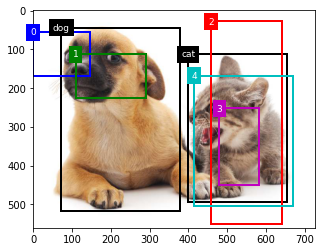

In [ ]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

Veamos que nos devuleve la función recien creada.

In [ ]:
# La función usara esto con minilotes, por eso necesitamos agregar número de
# ejemplos. En este caso, es un unico ejemplo, por eso agregamos unsqueeze

labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))



Nuestra función nos devuelve 3 elementos en una tupla

El tercero de ellos tiene la clase identificada, con la numeración discutida anteriormente. $n + 1$ clase numeradas de $0$ a $n$ donde $0$ es el fondo

Podemos ver que esto coincide con la forma en que asignamos clases y como funciona nuestra función para índice de Jaccard



In [ ]:
jaccard = box_iou(anchors, ground_truth[:,1:])
jaccard

tensor([[0.05, 0.00],
        [0.14, 0.00],
        [0.00, 0.57],
        [0.00, 0.21],
        [0.00, 0.75]])

In [ ]:
print(labels[2])
print(labels[2].reshape(-1,1))

tensor([[0, 1, 2, 0, 2]])
tensor([[0],
        [1],
        [2],
        [0],
        [2]])


El segundo elemento es un máscara. Usaremos está máscara para descartar los offsets asociados al fondo. Esto se debe a que estos valores carecen de significado. Además no queremos que estos valores contribuyan a nuestra función de pérdida. 

Para entender como enmascaramos los offsets debemos, podemos reestructurar la forma de nuestro segundo elemento. Al hacerlo vemos que se enmascara los 4 valores del offset en la representación `(x_centro, y_centro, ancho, alto)`


In [ ]:
print(labels[1])
print(labels[1].reshape(-1,4))

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])
tensor([[0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.]])


Por último, tenemos nuestros offsets, donde ya hemos aplicado nuestra máscara. De esta manera, los offsets asociados al fondo valen 0

In [ ]:
print(labels[0])
print(labels[0].reshape(-1,4))

tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  1.40e+00,  1.00e+01,
          2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
         -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -5.71e-01, -1.00e+00,
          4.17e-06,  6.26e-01]])
tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00],
        [ 1.40e+00,  1.00e+01,  2.59e+00,  7.18e+00],
        [-1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00],
        [-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00],
        [-5.71e-01, -1.00e+00,  4.17e-06,  6.26e-01]])


## Predicción de Bounding Boxes con supresión de no máximos (NMS).

Luego de entrenar nuestro modelo, debemos combinar nuestros offsets con nuestros anchor boxes para entregar un bounding box. Para esto debemos deshacer lo que hizo la función `offset_boxes`. Implmentaremos esto en la función `offset_inverse`

In [ ]:
def offset_inverse(anchors, offset_preds):
    """Predict bounding boxes based on anchor boxes with predicted offsets."""
    anc = box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = box_center_to_corner(pred_bbox)
    return predicted_bbox

Sin embargo, no podemos corregir todas nuestras anchor boxes con sus respectivos offsets. Como dijimos, podemos tener **miles** de anchor boxes.

Debemos nuevamente seleccionar solo algunas anchor boxes para generar los bounding boxes finales. Para seleccionarlos usaremos supresión de no máximos. 

Para elegir que anchor box usar en cada caso, debemos calcular  la probabilidad de que la clase esté bien asignada. En ultima instancia esto corresponde a aplicar softmax. Durante la asignación de categorías detectadas, usamos un clasificador como los que conocemos. Por lo tanto, podemos usar softmax para calcular la probabilidad de acierto

Con esto podemos analizar el algoritmo de NMS

1. Asignamos clases y offsets, a cada anchor box
2. Calculamos la probabilidad de acierto, para cada anchor box
3. Ordenamos de mayor probabilidad a menor probabilidad las anchor boxes.
4. Tomamos el anchor box $B$ con mayor probabilidad de haber acertado
5. Calculamos el índice de Jaccard para los demás anchor boxes y el anchor box $B$
6. Eliminamos todos los anchor boxes que tienen índice de Jaccard superior a un determinado umbral
  > hemos **suprimido** los anchor boxes **no máximos**
7. Agregamos $B$ a una lista $L$ y lo eliminamos de las anchor boxes a analizar.
8. Reperimos desde 2 hasta que no tengamos más anchor boxes para analizar.
9. Devolvemos la lista $L$




In [ ]:
def nms(boxes, scores, iou_threshold):
    """Sort confidence scores of predicted bounding boxes."""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # Indices a ser devuletos
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        ## Jaccard entre la anchor box de mayor confianza y las demas.
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        #                     ^ eliminamos el primero
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1] # + 1 porque elimine el primero a la entrada de box_iou
    return torch.tensor(keep, device=boxes.device)

La variable `inds` es una lista de enteros, vemos que pasa si usamos esto para el método `__getitem__` de un tensor.

In [ ]:
C = torch.randn(4)


print(C)
print(C[[3,1]])

tensor([1.31, 0.19, 0.89, 0.27])
tensor([0.27, 0.19])


Finalmente combinamos esto en una función que predice bounding boxes usando `nms`

In [ ]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """Predict bounding boxes using non-maximum suppression."""

    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []

    for i in range(batch_size):
        # Tomamos la probabilidad de cada clases y los offsets predichios
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0) ## [1:], no nos interesa el background.
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # Queremos buscar aquellos indices que no fueron seleccionados tras NMS

        # todos los indice
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        # todos los indices + los que queremos mantere
        combined = torch.cat((keep, all_idx))
        # los indices que no se repiten, corresponden a fondo.
        # por lo tanto no los conservamos
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1] #no conservar
        
        # actualizamos las clases asignadas y las ordenamos, poniendo primero
        # las que no son fondo
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        # tambien ordenamos, CON EL MISMO ORDEN, los de más tensores
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]

        # Si la confianza o la probabilidad de acertar a la clase es muy baja
        #  la tratamos como si fuera fondo.
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        # Pero ahora debemos convertir la probabilidad de ser una clase
        # a probabilidad de ser fondo.
        conf[below_min_idx] = 1 - conf[below_min_idx] ## confianza de ser background
        
        # 'empaquetamos' la salida.
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

Vemos ejemplos de esto, con sus respectivas imágenes.

In [ ]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                      [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # Predicted background likelihood
                      [0.9, 0.8, 0.7, 0.1],  # Predicted dog likelihood
                      [0.1, 0.2, 0.3, 0.9]])  # Predicted cat likelihood

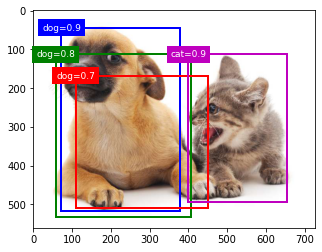

In [ ]:
fig = plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

Veamos que noes devuelve nuestra función

In [ ]:
# La función usara esto con minilotes, por eso necesitamos agregar número de
# ejemplos. En este caso, es un unico ejemplo, por eso agregamos unsqueeze

output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

Notemos que:

* `-1` corresponde al fondo
* Usamos las coordenadas de tal manera que el ancho y el alto de la imagen es igual a 1


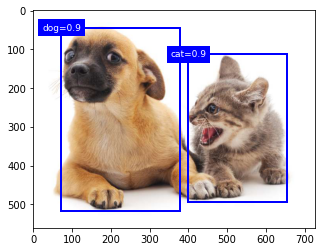

In [ ]:
fig = plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:# eliminamos el fondo
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

En la práctica, podemos eliminar los bounding boxes predichos con menor confianza incluso antes de aplicar  NMS, lo que reduce el tiempo de cálculo en este algoritmo.
También podemos posprocesar la salida de NMS, por ejemplo, manteniendo solo
resultados con mayor confianza
en la salida final.


# Detección de objetos a múltiples escalas


Generamos múltiples anchor boxes centrados en cada píxel de una imagen de entrada.
Esencialmente estos anchor boxes
representan muestras de
diferentes regiones de la imagen.
Sin embargo,
si se generan anchor boxes para *cada* píxel, tendremos demasiados.
En una imagen de entrada de $561 \times 728$,
si usamos cinco tipos de anchor boxes
se generan para cada píxel,
más de dos millones de cajas ancla ($561 \times 728 \times 5$). Además, estás cajas deben etiquetarse y asociarse a una categoría de la imagen.

## Anchor Boxes Mulstiescala

No es difícil reducir el número de anchor boxes en una imagen.
Por ejemplo, podemos simplemente
tomar muestra uniforme de de píxeles
de la imagen de entrada
para generar anchor boxes centrados en ellos.
También podemos aprovechar el hecho de que 
a diferentes escalas
podemos generar diferentes números de anchor boxes
de diferentes tamaños.
Intuitivamente,
los objetos más pequeños son más probables
aparecer en una imagen que las más grandes.
Como ejemplo,
objetos de tamaño $1 \times 1$, $1 \times 2$ y $2 \times 2$
puede aparecer en una imagen de $2 \times 2$
de 4, 2 y 1 formas posibles, respectivamente.
Por lo tanto, cuando usamos anchor boxes pequeñas para detectar objetos pequeños, podemos muestrear más regiones,
mientras que para objetos más grandes podemos muestrear menos regiones.

Ahora mostraremos cómo generar anchor boxesanclaje
a múltiples escalas a partir de una imagen leamos una imagen.
Usaremos la imágen del perro y el gato, la misma tiene dimensiones $561 \times 728$ píxeles.

In [ ]:
%matplotlib inline
import torch

img = plt.imread('catdog.jpg')
h, w = img.shape[:2]
h, w

(561, 728)

Recuerde: el mapa de características es la salida bidimensional de
una capa convolucional. De esta maner a podemos usar lo elementos de un mapa de características para los centros de anchor boxes muestreadas uniformemente en cualquier imagen.

Se define la función `display_anchors` a continuación.
Para ellos generaremos anchor boxes (`anchor`) en el mapa de características (`fmap`) usando cada elemento o píxel como el centro del anchor boxes.
Los valores de las coordenadas $(x, y)$
en los anchor boxes (`anchor`) se han dividido por el ancho y el alto del mapa de características (`fmap`). Por lo tanto $(x, y)$ toma valores están entre 0 y 1. Es decir, son las posiciones relativas de los
anchor boxes en el mapa de características.

Dado que centros de las anchor boxes (`anchor`)
corresponden a los píxeles en el mapa de características (`fmap`),
los centros estan distribuidos * uniformemente *
en la imagen de entrada por medio de sus posiciones espaciales relativas.
Por lo tanto, dado el ancho y la altura del mapa de características `fmap_w` y `fmap_h`, nuestra función muestrea *uniformemente* los píxeles en filas `fmap_h` y columnas `fmap_w`
para cualquier imagen de entrada.
Centrado en estos píxeles, crearemos anchor boxes con factores de escala `s` y aspect ratio definidos en un lista.


In [ ]:
def display_anchors(fmap_w, fmap_h, s):
    # Values on the first two dimensions do not affect the output
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    show_bboxes(plt.imshow(img).axes,
                    anchors[0] * bbox_scale)

Analicemos esto para 3 casos:

* Un muestreo uniforme de $4 \times 4$
* Un muestreo uniforme de $2 \times 2$
* Anchor boxes centradas en la imagen original

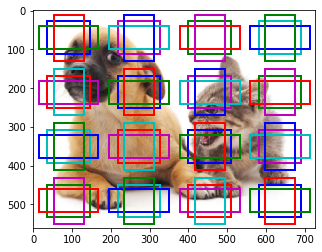

In [ ]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

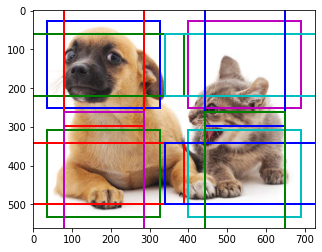

In [ ]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

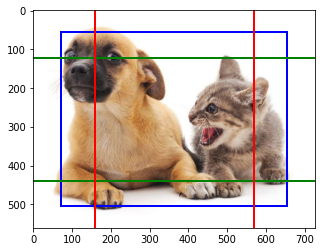

In [ ]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])

Observe que a diferentes escalas ponemos diferentes valores de `s`, para evitar superposición entre los anchor boxes

##  Detección Multiscala


Hasta aquí hemos generado anchor boxes multiescala para detectar objetos de varios tamaños a diferentes escalas.

Consideremos un caso donde tenemos un mapa de características de $4 \times 4$ mapas con 10 canales. Usando nuestra función generamos 16 conjuntos de anchor boxes, donde cada conjunto contiene 3 tipos de anchor boxes. Cada conjunto de anchor boxes tiene el mismo centro.

Ahora bien estos 10 canales tienen información de la imagen original. Por lo tanto, para cada píxel del mapa de características tenemos 10 valores con información de nuestra imagen original. Además, cada píxel ahora tiene asociado un conjunto de anchor boxes. Dicho de otro modo, podemos usar esos 10 canales para obtener información sobre el objeto que está dentro de nuestro anchor box y sobre como corregir la forma de nuestro anchor box para que el rectángulo coincida mejor con el objeto. 

Este será el procedimiento a usar en nuestro detector. Pero esto lo veremos más adelante.


# Un dataset para detección de objetos

No existe un dataset pequeño como MNIST y Fashion-MNIST en el campo de la detección de objetos.
Sin embargo, para demostrar rápidamente los modelos de detección de objetos,
usaremos 1000 imágenes de bananas con diferentes rotaciones y tamaños en una posición aleatoria en alguna imagen de fondo.
Al final, etiquetamos bounding boxes para las bananas en las imágenes.

## Descargando el dataset

In [ ]:
import os
import pandas as pd
import torch
import torchvision
from shutil import unpack_archive


## Lectura del conjunto de datos

Vamos a leer el conjunto de datos de detección de bananas en la función `read_data_bananas`.
El dataset incluye imágenes con bananas, un archivo csv para
etiquetas de clase de objeto y
coordenadas del bounding box. Este baounding box está en la representación de las esquinas superior izquierda e inferior derecha.

In [ ]:
!wget -O banana-detection.zip http://d2l-data.s3-accelerate.amazonaws.com/banana-detection.zip

def read_data_bananas(is_train=True):
    """Read the banana detection dataset images and labels."""
    if not os.path.isdir("banana-detection"):
        unpack_archive('./banana-detection.zip', extract_dir='./', format='zip')

    csv_fname = os.path.join('banana-detection', 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join('banana-detection', 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # `target` contiene 5 valores
        #(clase, x_superior_izq, y_superior_izq, x_inferior_der, y_inferior_der)
        # Recordemos que en este caso solo tenemos bananas (clase = 0)
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

--2022-09-24 13:32:24--  http://d2l-data.s3-accelerate.amazonaws.com/banana-detection.zip
Resolving d2l-data.s3-accelerate.amazonaws.com (d2l-data.s3-accelerate.amazonaws.com)... 13.35.16.37
Connecting to d2l-data.s3-accelerate.amazonaws.com (d2l-data.s3-accelerate.amazonaws.com)|13.35.16.37|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139442012 (133M) [application/zip]
Saving to: ‘banana-detection.zip’

banana-detection.zi 100%[===================>] 132.98M  30.5MB/s    in 5.4s    

2022-09-24 13:32:30 (24.7 MB/s) - ‘banana-detection.zip’ saved [139442012/139442012]



Usaremos la función `read_data_bananas` para leer imágenes y etiquetas.
La siguiente clase `BananasDataset`nos permitirá crear una instancia `Dataset` personalizada para cargar los datos de detección de bananas.

In [ ]:
class BananasDataset(torch.utils.data.Dataset):
    """A customized dataset to load the banana detection dataset."""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

Finalmente, definimos
la función `load_data_bananas` para devolver dos
instancias de iterador de datos: uno para los los datos de entrenamiento y otro para los de prueba.
Para el conjunto de datos de prueba, no hay necesidad de leerlo en orden aleatorio.

In [ ]:
def load_data_bananas(batch_size):
    """Load the banana detection dataset."""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

Vamos a leer un minilote e imprimir las formas de las imágenes las etiquetas de ese minilote.
La forma del minilote de imágenes es 

`[tamaño del lote, número de canales, alto, ancho]`

Ests estructura ya la conocíamos.

La forma del minilote de etiquetas es

`[tamaño del lote, m, 5]`

donde $m$ es el mayor número posible de bounding boxes
que cualquier imagen tiene en el conjunto de datos.

Aunque el cálculo en minilotes es más eficiente, requiere que todos los ejemplos de imágenes contengan el mismo número de bounding boxes cuadros delimitadores para formar un minilote a través de la concatenación. En general, las imágenes pueden tener un número variable de bounding boxes. De este modo imágenes con menos de $m$ bounding boxes, se rellenan con bounding boxes que no contienen objetos hasta llegar a las $m$ bounding boxes necesarias.

La etiqueta de cada bounding box está representada por 5 valores. El primer elemento es la clase del objeto en el bounding, donde -1 indica un bounding box vacío, es decir, un bounding box con fondo

Los cuatro elementos restantes de la matriz son los valores de las coordenadas ($x$, $y$) de la esquina superior izquierda y la esquina inferior derecha  ( los valores de las coordenadas están en el rango está entre 0 y 1).

Para nuestro dataset tenemos solo bananas, con lo que tenemos $m=1$.

In [ ]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

## Ejemplos

Demostremos diez imágenes con sus bounding boxes
Podemos ver que las posiciones de las bananas varían en todas estas imágenes. Por supuesto, esto son datos artificiales. En la práctica, los datasets del mundo real suelen ser mucho más complicados.

In [ ]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        try:
            img = img.detach()
        except:
            pass
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes


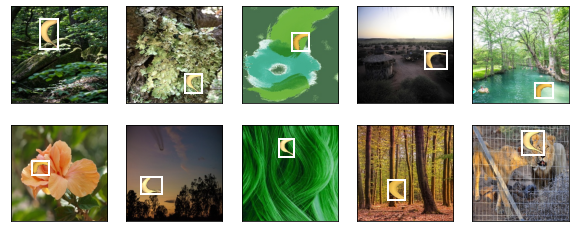

In [ ]:
imgs = (batch[0][:10].permute(0, 2, 3, 1)) / 255
axes = show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][:10]):
    show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

# *Single Shot Multibox Detection*

Ahora estamos en condiciones de armar nuestro modelo de detección de objetos. Para ellos usaremos un tipo de modelo llamado single shot multibox detection (SSD)

Este modelo es simple, rápido y muy popular. A pesar de no ser el único modelo existente, la implementación cubre la mayoría de los por menores existentes en otros modelos.  

## Modelo

En la siguinte figura mostramos una descripción general del modelo SSD. Este modelo consiste principalmente en una red básica seguida por varios bloques de mapas de características multiescala.

![](http://d2l.ai/_images/ssd.svg)

La red básica es usada para extraer características de la imagen de entrada por medio de una CNN. Después, sucesivos bloques de CNN reducen la altura y el ancho de los mapas de características originales dando lugar a mapas de características multiescala. Los mapas de cáracterísticas multiescala, son mápas de características de diferentes tamaños. Mientras más chico es el mapa de características, más grande es el campo receptivo de cada elemento del mapa. Por lo tanto, los mapas de características más chicos nos permiten detectar objetos más grandes. Este es un punto que habíamos discutirdo anteriormente.

De esta manera, a través de la red base y de los mapas de características multiescala, SSD genera anchor boxes con diferentes tamaños. Luego, detecta objetos de diferentes tamaños mediante la predicción de clases y el cálculo offsets. Como todo esto ocurre en el paso foward de la red, decimos que detectamos en un unico disparo. De allí el nombre *single shot detection*. Por lo anterior, se dice que este es un modelo de detección de objetos multiescala.



### Predicción de clase

Para predecir la clase del objeto dentro un anchor box usaremos los diferentes canales de los mápas de características. De esta manera, analizando los canales de cada elemento de nuestro mapa de características predeciremos qué objeto hay en su campo receptivo.

Para implementar este clasificador, usaremos una CNN que toma los canales de nuestro mapa de características. Si $a$ es el número de anchor boxes que genera nuestro modelo y $n$ es el número de tipos de objetos de nuestro dataset, la convolución devuelve $a (n + 1)$ canales. Esto es, para cada tipo de anchor box tratamos de predecir si detectamos algun objeto de interes. Como podemos haber detectado solo nuestro fondo, debemos agregar $+1$ para descartar correctamente el fondo. 



In [ ]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F


def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

### Cálculo de offset

La capa que predice offsets, tambien toma los canales del mapa de características y predice algo. En este caso, debemos predecir 4 offsets para cada anchor box. De esta manera el número de canales a la salida es $4a$

In [ ]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

### Concatenación y predicciones a múltiples escalas

Como mencionamos, la SSD utiliza mapas de características multiescala para generar cuadros de anclaje y predecir sus clases y offsets. A diferentes escalas, las formas de los mapas de características, la cantidad de canales o los tipos anchor boxes por elemento pueden variar.
Por lo tanto, formas de las salidas de la capa de predicción puede variar a diferentes escalas.

En el siguiente ejemplo, construimos mapas de características en dos escalas diferentes, 'Y1' y 'Y2', para el mismo minilote. En ese ejemplo la altura y el ancho de `Y2` son la mitad de los de `Y1`. Tomemos la predicción de clase como ejemplo. Supongamos tenemos 5 tipos de anchor boxes para los elementos de `Y1` y 3 tipos de anchor boxes para los elementos de `Y2`.

Supongamos además que el número de clases de objetos es 10.
Para mapas de características `Y1` y `Y2`, los números de canales en las salidas de la capa de predicción son $5\times(10+1)=55$ y $3\times(10+1)=33$

En todos los casos el tensor de salida tiene la forma:

`[tamaño del lote, número de canales, alto, ancho]`


In [ ]:
#esta función aplica el bloque `block` al tensor x
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

Como podemos ver, a excepción de la dimensión del tamaño del lote, las otras tres dimensiones tienen diferentes tamaños. Concatenaremos estas dos salidas de predicción para un cálculo más eficiente. Para ello, transformaremos estos tensores en un formato más consistente.

El tensor final tendra la forma 

`[tamaño del lote, alto * ancho * número de canales]`

de esta manera podemos concatenar en la dimensión 1

La salida detallada, nos impone que nuestra salida pasé de una representación de la forma

`[tamaño del lote, número de canales, alto, ancho]`

a otra de la forma:

`[tamaño del lote, alto, ancho, número de canales]`


In [ ]:
# cambio de forma y aplanamiento
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

# concatenación
def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

Ahora podemos concatenar las salidas.

In [ ]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

### Bloque de downsampling

Para detectar objetos a múltiples escalas, definimos el bloque de downsampling en la función  `down_sample_blk`. Esta función reduce a la mitad la altura y el ancho de los mapas de características de entrada.

Cada bloque de downsampling consta de dos capas convolucionales con kernel $3\times3$ y padding igual a 1. Tras estas dos capas hay un MaxPooling $2\times2$ con una stride igual a de 2.

Como sabemos, las capas convolucionales de $3\times3$ con relleno de 1 no cambian la forma de los mapas de características. Sin embargo, el MaxPooling de $2\times2$ reduce la altura y el ancho de los mapas de características de entrada a la mitad.

De esta manera, al achicar el tamaño de nuestro mapa de características, aumentamos el campo receptivo de cada elemento del mapa


In [ ]:
def down_sample_blk(in_channels, out_channels):
    ## creamos una lista de capas...
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    ## ... y luego las conectamos en un Sequential
    return nn.Sequential(*blk)

En el siguiente ejemplo, el bloque de downsampling reduce el mapa de características a la mitad.

In [ ]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

### Red base del modelo SSD

Esta red base es un bloque que usamos para extracción de características. En este ejemplo creamos una red que consiste de 3 bloques de downsampling como los ya discutidos. Es importante destacar que en cada paso de downsampling, duplicamos el número de canales that double the number of channels at each block.

Dada una imagen de $256\times256$ a la entrada, a la salida de la red base tenemos una salida de $32 \times 32$ ($256/2^3=32$).


In [ ]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

### Modelo final

El modelo final tendra 5 bloques bien diferenciados. 

1. Red base
2. Bloque de downsampling
3. Bloque de downsampling
4. Bloque de downsampling
5. MaxPooling final 

Este pooling final reduce el mapa de características a un tamaño $1\times 1$. Para esto usamos la capa `AdaptiveMaxPool2d()`



En cada bloque, los mapas de características son usados para:

* Generar anchor boxes
* Predecir la clase de objeto dentro del anchor box
* Predecir los offsets para encontrar el bounding box correcto



In [ ]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

Definimos también una función de foward para cada bloque. En este caso queremos tener 3 salidas:

1. Mapa de características a la salida del bloque
2. Anchor Boxes generadas usando el mapa de características
3. Clase de objeto predicha para anchor box
4. Offset para el anchor box


In [ ]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

Como trabajamos con diferentes tamaños de anchor boxes a diferentes escalas, debemos asignar diferentes tamaños de anchor boxes a diferentes escalas. Recordemos que la funcion `multibox_prior` requería una lista de tamaños en el argumento `sizes`. A continuación, definimos una lista de listas. La $i$-ésima lista, es la lista de tamaños a usar en el $i$-ésimo bloque. Decidimos omitir el origen de los números usado para evitar que la clase se prolongue demasiado.

Por otro lado, argumento `ratios` de la funcion `multibox_prior` no presenta el problema anterior. Esto se debe a que ratio es un cociente longitudes. Por lo tanto, a cada bloque podemos pasarle la misma lista de ratios.


In [ ]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

Ahora sí, con todas la herramientas anteriores armaremos la clase `TinySSD` a partir de `Module`


In [ ]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # setattr es aquivalente a `self.blk_i = get_blk(i)`
            # La única diferencia es que el nombre es creado dinámicamente
            #     `self.blk_0`
            #     `self.blk_1`
            #     `self.blk_2`
            #     `self.blk_3`
            #     `self.blk_4`
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        ### Tenemos 5 bloques
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # `getattr(self, 'blk_%d' % i)` equivale a acceder a self.blk_i`
            # En cada iteración, generamos 
            #     1. Mapa de características a la salida del bloque
            #     2. Anchor Boxes generadas usando el mapa de características
            #     3. Clase de objeto predicha para anchor box
            #     4. Offset para el anchor box
            # En cada nueva iteración, usaremos el nuevo mapa de características
            # para generar el siguiente mapa de características
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        # Luego concatenamos todo
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

Creemos un minilote ficticio para verificar que la red procese las entradas correctamente. Como nuestro dataset tiene imagenes RGB de la forma $256 \times 256$, usaremos un minilote de estas características..

A la salida del primer bloque tenemos salidas con tamaño $32 \times 32$. Luego los siguientes bloques reducen el tamaño a la mitad, excepto el último que devuelve $1 \times 1$. 

Al final de todo este proceso, tenemos  la siguinte cantidad de anchor boxes 
$(32^2 + 16^2 + 8^2 + 4^2 + 1)\times 4 = 5444$


In [ ]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


## Entrenamiento.

En primer lugar debemos cargar nuestros datos de entrenamiento

In [ ]:
batch_size = 32
train_iter, val_iter = load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


Luego inicializamos nuestro modelo y el optimizador. Observemos que nuestro modelo solo detecta bananas, por lo que solo tenemos 1 clase.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = TinySSD(num_classes=1) # solo detectamos bananas
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

### Funciones de pérdida y métricas

La detección de objetos necesita dos tipos de funcioens de pérdida.
  * La primera pérdida es un clasificador: define la clase de objeto dentro de una anchor box. De más está decir que para esto usaremos entropía cruzada
  * La segunda pérdida debe solucionar un problema de regresión: calcula los offsets de los anchor boxes para llegar a la bounding box de nuestro dataset. Sin embargo, en lugar de usar mínimos cuadrados usaremos el valor absoluto de la diferencia entre la predicción y la la etiqueta de nuestro dataset.

Además, la función de pérdida debe ignorar aquellas anchor boxes que detectaron el fondo. Para esto en mascaramos con la variable `bbox_masks` las anchor boxes que no detectaron objetos de interes

Presentamos la función de perdida a continuación


In [ ]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    # Enmascaramos con bbox_masks
    # Estas máscaras eran generadas por la función `multibox_target`
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

También agregaremos métricas para evaluar nuestro modelo. Una de ellas sea el `accuracy` como ya lo conocemos y la otra será el error absoluto medio, MAE (mean absolute error)


In [ ]:
def cls_eval(cls_preds, cls_labels):
    # `argmax`aplica en la última dimensión como estamos acostumbrados
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

### Ciclo de entrenamiento

Al entrenar el modelo, necesitamos generar anchor boxes (`anchors`), predecir sus clases (`cls_preds`) y predecir sus offsets (`bbox_preds`). Todo esto ocurre durane el paso forward. Luego usamos la función `multibox_target` para asignar las clases (`cls_labels`) y los offsets (`bbox_labels`) de nuestros anchor boxes en función de la etiqueta de nuestros datos. Finalmente, calculamos la función de pérdida usando los valores predichos y etiquetas de la función `multibox_target`

In [ ]:
num_epochs= 20

net = net.to(device)
# Iniciamos la mejor pérdida de validación en infinito.
# De esta manera guardaremos mejores valores de funcion de pérdida, y los 
# respectivos mejores modelos
best_valid_loss = float('inf') 
for epoch in range(num_epochs):

    # Inicalizamos acumuladores para las métricas a presentar
    cls_err, cls_elem, bbox_mae, bbox_elem = 0, 0, 0, 0
    loss, loss_elem = 0, 0
    net.train()
    for features, target in train_iter:
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # Generamos anchor boxes,
        # predecimos clases de objeto detectado y 
        # offsets de bounding box
        anchors, cls_preds, bbox_preds = net(X)

        # Asignamos clases y offsets, usando las etiquetas del dataset
        bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, Y)
        
        # Usamos las etiquetas de multibox_target y las predicciones de 
        # nuestro modelo para calcular la función de pérdida
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        
        # Actualizamos los valores para las metricas a reportar
        loss += l.sum()
        loss_elem += l.numel()

        # Paso de optimización
        l.mean().backward()
        trainer.step()
        
        # Actualizamos más valores para las metricas a reportar
        cls_err += cls_eval(cls_preds, cls_labels)
        cls_elem += cls_labels.numel()
        bbox_mae += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
        bbox_elem += bbox_labels.numel()

    # Calcumamos la métricas finales.
    cls_err, bbox_mae, loss = 1 - cls_err / cls_elem, bbox_mae / bbox_elem, loss / loss_elem
    
    # Inicalizamos acumuladores para las métricas en los datos de validación
    val_loss, val_loss_elem = 0, 0
    net.eval() # evitamos calculo de gradientes

    # Nos asguramos que no haya gradientes 
    with torch.no_grad():
        for features, target in val_iter:
            trainer.zero_grad()
            X, Y = features.to(device), target.to(device)
            
            # Generamos anchor boxes,
            # predecimos clases de objeto detectado y 
            # offsets de bounding box
            anchors, cls_preds, bbox_preds = net(X)

            # Asignamos clases y offsets, usando las etiquetas del dataset
            bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, Y)
            
            # Usamos las etiquetas de multibox_target y las predicciones de 
            # nuestro modelo para calcular la función de pérdida
            l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                          bbox_masks)
            # Actualizamos los valores para las metricas a reportar
            val_loss += l.sum()
            val_loss_elem += l.numel()

        # Calcumamos la métricas finales.
        val_loss = val_loss / val_loss_elem

    # Si la nueva pérdida del dataset de validación es menor a la mejor
    # pérdida de validación, guardamos el modelo
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(net.state_dict(), 'banana_detector.pt')

    # imprimimos métricas por época.
    print(f'EPOCH: {epoch + 1}')
    print(f'    training loss {loss:.2e}')
    print(f'    validation loss {val_loss:.2e}')
    print(f'    class err {cls_err:.2e}')
    print(f'    bbox mae {bbox_mae:.2e}')


EPOCH: 1
    training loss 8.07e-02
    validation loss 4.41e-02
    class err 2.69e-02
    bbox mae 5.51e-03
EPOCH: 2
    training loss 3.01e-02
    validation loss 2.94e-02
    class err 4.85e-03
    bbox mae 5.19e-03
EPOCH: 3
    training loss 2.60e-02
    validation loss 2.52e-02
    class err 4.85e-03
    bbox mae 5.07e-03
EPOCH: 4
    training loss 2.35e-02
    validation loss 2.29e-02
    class err 4.85e-03
    bbox mae 4.99e-03
EPOCH: 5
    training loss 2.20e-02
    validation loss 2.18e-02
    class err 4.85e-03
    bbox mae 4.94e-03
EPOCH: 6
    training loss 2.06e-02
    validation loss 1.94e-02
    class err 4.84e-03
    bbox mae 4.88e-03
EPOCH: 7
    training loss 1.97e-02
    validation loss 1.89e-02
    class err 4.76e-03
    bbox mae 4.80e-03
EPOCH: 8
    training loss 1.85e-02
    validation loss 1.04e-01
    class err 4.54e-03
    bbox mae 4.65e-03
EPOCH: 9
    training loss 1.76e-02
    validation loss 1.70e-02
    class err 4.26e-03
    bbox mae 4.43e-03
EPOCH: 10


## Predicción

Durante la predicción, el objetivo es detectar todos los objetos de interés en la imagen. A continuación, leemos y redimensionamos una imagen de prueba, convirtiéndola en un tensor de cuatro dimensiones que requieren las capas convolucionales.

`[tamaño de minilote, número de canales, alto, ancho]`

In [ ]:
!wget -O banana.jpg https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/banana.jpg

# Cargamos una imagen para analizar predicciones
X = torchvision.io.read_image('banana.jpg').unsqueeze(0).float()

# Consideamos la imagen y la imagen reflejada en el eje x
img = X.squeeze(0).permute(1, 2, 0).long()
img2 = X[:,:,range(255,-1,-1),:].squeeze(0).permute(1, 2, 0).long()

--2022-09-24 13:35:05--  https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/banana.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44367 (43K) [image/jpeg]
Saving to: ‘banana.jpg’

banana.jpg          100%[===================>]  43.33K  --.-KB/s    in 0.004s  

2022-09-24 13:35:05 (9.91 MB/s) - ‘banana.jpg’ saved [44367/44367]



A partir de los anchor boxes y los offsets predichos se calculan los bounding boxes usando la función `multibox_detection`. Recordemos que está función usa NMS (Non-Maximum Supression) para elegir los mejores bounding boxes

In [ ]:
def predict(X):
    net.eval()# No calculamos gradientes

    # Obtenemos la salidas de nuestro modelo
    anchors, cls_preds, bbox_preds = net(X.to(device))

    # cls_preds es de la forma
    # [tamaño de minilote, número de anchor boxes, número de clases + 1]

    # Elegimos la clase más probable, usando softmax
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)

    # Usamos NMS para elegir las mejores bounding boxes predichas
    output = multibox_detection(cls_probs, bbox_preds, anchors)

    # Devolvemos solo las bounding boxes que encontrario objetos
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

net.load_state_dict(torch.load('banana_detector.pt'))

# Predecimos para la imagen y la imagen reflejada en el eje x
output = predict(X)
output2 = predict(X[:,:,range(255,-1,-1),:])

Finalmente, usamos matplotlib para mostrar nuestras predicciones. Mostramos las bounding boxes con probabilidad superior a 0.9 de ser correctas

In [ ]:
def display(img, output, threshold):
    fig = plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')


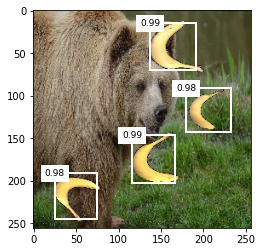

In [ ]:
display(img, output.cpu(), threshold=0.9)

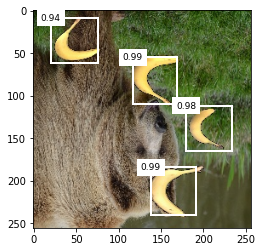

In [ ]:
display(img2, output2.cpu(), threshold=0.9)

# CNN basadas en regiones (R-CNNs)

Además del modelo SSD descrito, las CNN basadas en regiones (R-CNN) son otro de los enfoques usados en la detección de objetos que usa las ténicas de Deep Learning. Debido al espacio limitado, solo nos centraremos en describir de estos modelos.


## R-CNNs


![](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/r-cnn.svg?raw=1)


La figura muestra la manera como funciona una R-CNN. Esto algortimos consta de 4 pasos

1. Por medio de una un algortimo conocido como *selective search*, se proponen muchas regiones que tienen altas probabilidades de contener objetos de interes. Estas regiones tienen formas y tamaños distintos a diferentes escalas. A cada region se le asigna una etiqueta y un offset como se describió anteriormente.
1. Elejimos una CNN preentrenada para clasificación y eliminamos la última capa. Cambiamos el tamaño de cada región propuesta al tamaño de entrada requerida por la red. A la salida de la red se generará un vector de características para la región de interes. En esencia, lo que hemos hecho es transformar nuestra CNN preentrenada en un encoder de regiones propuestas
1. Usando los vectores de características y la clase asignada de cada región propuesta, entrenamos máquinas de vectores de soporte para clasificar objetos. Cada máquina de vectores de soporte determina individualmente si el ejemplo contiene una clase específica.
1. Usando los vectores de características y los offset asignados a cada región propuesta, entrenamos un modelo de regresión lineal para predecir la bounding box

Aunque el modelo R-CNN usa CNN preentrenadas para extraer características de la imagen, el proceso es lento. Imagine que seleccionamos miles de regiones propuestas a partir de una sola imagen de entrada: esto requiere miles de llamadas a la CNN para realizar la detección de objetos. La cantidad de cálculos necesarios hace que este mecanismo no sea viable en aplicaciones reales

## Fast R-CNN

La parte más lenta en el rendimiento de una R-CNN radica en el paso foward de la CNN, pues se realiza de manera independiente para cada imagen. Lo que es peor estas regiones generalmente tienen superposiciones, las extracciones de características independientes conducen a muchos cálculos repetidos. Una de las principales mejoras de *Fast R-CNN* con respecto a R-CNN es que el paso foward de la CNN solo se realiza en la imagen completa

![](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/fast-rcnn.svg?raw=1)


La figura  muestra como funciona el modelo fast R-CNN model.

1. A diferencia de R-CNN, en Fast R-CNN, la entrada de la CNN para la extracción de características es la imagen completa, en lugar de propuestas de regiones individuales. Además, esta CNN es entrenable. Para una imagen de entrada, la salida de la CNN es $1 \times c \times h_1 \times w_1$.
1. *Selective search* genera $n$ regiones propuestas. Estas regiones propuestas definen regiones de interés (RoI) a la salida de CNN. Las regiones de interés pueden usarse para extraer aún más características. Para lograr esto, Fast R-CNN utiliza la capa de pooling conocida como *RoI Pooling* o pooling para región de interés. La salida de CNN y las regiones propuestas ingresan en esta capa de pooling, generando características concatenadas de forma $n \times c \times h_2 \times w_2 $, donde $h_2 \times w_2$ es el tamaño de RoI.
1. Usando una capa densa, se toman las caracteríscas a la salida de CNN y RoI Pooling para generar una salida de forma $n \times d$, donde $d$ depende del diseño del modelo de Fast R-CNN.
1.Con la salida de la capa densa, aplicamos dos capas densas más. Una de ellas predice la clase y la otra predice el offset cada una de las $n$ regiones propuestas. La salida de la capa de predicción de clases tiene la forma forma $n \times q$ ($q$ es el número de clases). La salida de la capa que predice offset tiene la forma $n \times 4$. La predicción de clase utiliza la regresión softmax.

La capa de pooling de región de interés es diferente de las capas de pooling que ya conocemos. En la capa de agrupación, controlamos indirectamente la forma de salida al especificar los tamaños de la ventana de pooling, el padding y el stride. Por el contrario, en una capa de pooling de region de interes podemos especificar directamente la forma de salida.

Por ejemplo, especifiquemos la altura y el ancho de salida para cada región como $h_2$ y $w_2$, respectivamente. Para cualquier ventana de región de interés de forma $h \times w$, esta ventana se divide en una cuadrícula de subventanas $h_2 \times w_2$, donde la forma de cada subventana es aproximadamente $(h/h_2) \times (w/ w_2)$. En la práctica, la altura y el ancho de cualquier subventana se redondearán hacia arriba. Luego el elemento más grande se utiliza como salida de la subventana. Es decir, aplicamos una función máximo: RoI Pooling es un tipo de Max Pooling. Al final, la capa de RoI Pooling puede extraer características de la misma forma incluso cuando las regiones de interés tienen formas diferentes.

En la siguiente figura, la región de interés superior izquierda $3\times 3$ se selecciona a partir de una entrada de $4 \times 4$. Para esta región de interés, usamos una capa de RoI Pooling $2\times 2$ para obtener una salida de $2\times 2$. Observamos los elementos en cada una de las cuatro subventanas definidas: 

* 0, 1, 4 y 5 (5 es el máximo)
* 2 y 6 (6 es el máximo)
* 8 y 9 (9 es el máximo)
* 10

![](http://d2l.ai/_images/roi.svg)


Abajo mostramos como funciona RoI Pooling. Consideremos una CNN cuya salida final es de la forma $4 \times 4$ con ún unico canal.


In [ ]:
import torch
import torchvision

X = torch.arange(16.).reshape(1, 1, 4, 4)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

Supongamos  la altura y el ancho de la imagen de entrada son 40 píxeles y que la *selective search* genera dos regiones propuestas. Cada region propuesta tiene expresada como cinco elementos: su clase de objeto, seguida de las coordenadas $(x, y)$ de sus esquinas superior izquierda e inferior derecha.

In [ ]:
rois = torch.Tensor([[0, 0, 0, 20, 20], [0, 0, 10, 30, 30]])

Vemos que la altura y el ancho del mapa de características es un $1/10$ de la altura y el ancho de la imagen de entrada. Las coordenadas de las dos regiones propuestas se multiplican por 0.1 de acuerdo con el argumento `spatial_scale` especificado. Luego, las dos regiones de interés se marcan en `X` como `X[:, ::, 0:3, 0:3]` y `X[:, ::, 1:4, 0:4]`, respectivamente. Finalmente, en RoI Pooling con tamaño $2\times 2$, cada región de interés se divide en una cuadrícula de subventanas para extraer mapas de características de la forma $2\times 2$.

In [ ]:
torchvision.ops.roi_pool(X, rois, output_size=(2, 2), spatial_scale=0.1)

tensor([[[[ 5.,  6.],
          [ 9., 10.]]],


        [[[ 9., 11.],
          [13., 15.]]]])

## Faster R-CNN

El siguiente paso para mayor velocidad fue eliminar *selective search* para usar una CNN que proponga regiones.

![The faster R-CNN model.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/faster-rcnn.svg?raw=1)

En la figura anterior, se muestra que la única diferencia entre Fast R-CNN y Faster R-CNN es la manera en que se porponen regiones. 

1. Se usa una capa convolucional $3\times 3$ con un padding igual a 1 para transfomar la salida de la CNN en una nueva salida con canales $c$. De esta forma, cada elemento del mapa de características tiene un nuevo vector de características de longitud $c$.
1. Centrado en cada píxel de los mapas de características, generamos múltiples anchor boxes de diferentes escalas y aspect ratios. Luego etiquetamos estos anchor boxes.
1. Usando el vector de características de longitud $c$, predecimos la clase binaria (fondo u objetos) y el offset.
1. A paritr de los bounding boxes que contiene objetos de interes, eliminamos los resultados superpuestos utilizando una supresión no máxima. Los bounding boxes restantes  son regiones propuestas la capa de RoI Pooling.

Vale la pena señalar que, como parte del modelo Faster R-CNN, la red de regiones propuestas se entrena en conjunto con el resto del modelo. En otras palabras, la función pérdida de Faster R-CNN incluye no solo la clase y la predicción del offset en la detección de objetos, sino también la clase binaria y el offset  de los anchor boxes en la red que propone regiones. De esta manera la red aprende a crear mejores regiones propuestas, a la vez que mejora la precisión en la detección de objetos.




## R-CNN con máscaras

Se ha visto que si contamos con información, píxel a píxel de los objetos de interés, los resultados de detección de objeto mejoran. Es decir, si en lugar de tener un bounding box de una banana, tenemos etiquetados los pixeles que pertenecen a la banana y los píxeles que no pertenecen a la banana, los modelos de detección de objeto mejoran su rendimiento por mucho.

![](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/mask-rcnn.svg?raw=1)

Como se ve en la figura, el modelo de R-CNN con máscaras es una modificación de Faster R-CNN.
Al usar máscaras, el RoI Pooling se reemplaza por una capa de "alineamiento de RoI". Esta nueva capa, implementa una interpolación bilineal que permite predecir a que categoría pertenece cada píxel. Además, ahora predecimos clases, bounding boxes y clase pixel a píxel. Esta ultima predicción se realiza usando una red completamente convolucional...

... Pero la red completamente convolucional la explicaremos en la siguiente clase...


